<a href="https://colab.research.google.com/github/rafaellabastos/savvyfix-ia-notebook/blob/douglas/precificacao_dinamica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SavvyFix - Precificação dinâmica**

<p>2TDSPF</p>

<p>Douglas Magalhães de Araujo - 552008</p>
<p>Gustavo Argüello Bertacci - 551304</p>
<p>Luiz Fillipe Farias - 99519</p>
<p>Rafaella Monique do Carmo Bastos - 552425</p>

# **Dataset**

<p>Fonte: https://www.kaggle.com/code/jeffersonvalandro/analisando-inflacao-brasil/input?select=relatorio_preco_medio_mensal_2023.csv</p>

## Descrição do conjunto de dados
<p>O objetivo desse notebook é criar um modelo de Machine Learning utilizando a técnica de Regressão Linear para demonstrar os prováveis preços dinamizados ao longo dos meses com base nos meses anteriores.</p>
<p>Os dados foram coletados a partir da inflação dos produtos ao longo dos meses do ano de 2023.</p>
<p>Observação: com o tempo, este modelo será alimentado com dados a partir da localização, clima, demanda, procura e horário.</p>

## **Importação das bibliotecas**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

## **Inicialização do Data Frame**

In [ ]:
dados = pd.read_csv('relatorio_preco_medio_mensal_2023.csv')
dados.head()

,Produto/Unidade,Nível de Comercialização,U.F.,01/2023,02/2023,03/2023,04/2023,05/2023,06/2023,07/2023,08/2023,09/2023,10/2023,11/2023,12/2023
0,ABACATE (kg),ATACADO,RR,"6,83","6,67","6,83","7,00","7,00","6,00","6,00","6,60","7,00","7,00","7,00","7,00"
1,ABACAXI HAVAÍ (kg),PRODUTOR,PR,"1,85","2,31","2,30","2,30","2,30",NaN,NaN,NaN,NaN,NaN,"2,60","2,60"
2,ABACAXI (kg),ATACADO,RR,"2,59","2,65","2,79","6,00","8,00","4,50","4,50","4,95","5,00","7,50","7,00","7,50"
3,ABACAXI PÉROLA (6.50 kg),PRODUTOR,DF,"21,80","20,14","23,45","26,65","34,82","36,87","25,47","27,36","28,48","31,92","25,05","25,75"
4,ABACAXI PÉROLA (kg),NaN,AM,"3,81","3,75","3,75","3,90","4,00","4,25","4,02","3,94","4,27","4,25","4,51","4,23"


## **Visualização e tratamento do DataSet**

---



In [ ]:
# Quantidade de linhas e colunas do DataFrame
dados.shape

(2029, 15)

In [ ]:
# Nomes das colunas
dados.columns

Index(['Produto/Unidade', 'Nível de Comercialização', 'U.F.', '01/2023',
       '02/2023', '03/2023', '04/2023', '05/2023', '06/2023', '07/2023',
       '08/2023', '09/2023', '10/2023', '11/2023', '12/2023'],
      dtype='object')

In [ ]:
# Informação do formato de dados das colunas
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Produto/Unidade           551 non-null    object
 1   Nível de Comercialização  309 non-null    object
 2   U.F.                      2024 non-null   object
 3   01/2023                   1901 non-null   object
 4   02/2023                   1902 non-null   object
 5   03/2023                   1874 non-null   object
 6   04/2023                   1874 non-null   object
 7   05/2023                   1884 non-null   object
 8   06/2023                   1879 non-null   object
 9   07/2023                   1852 non-null   object
 10  08/2023                   1781 non-null   object
 11  09/2023                   1765 non-null   object
 12  10/2023                   1706 non-null   object
 13  11/2023                   1603 non-null   object
 14  12/2023                 

In [ ]:
# Exclusão de colunas sem importância
dados = dados.drop('Nível de Comercialização', axis=1)
dados = dados.drop('U.F.', axis=1)
dados.head()

,Produto/Unidade,01/2023,02/2023,03/2023,04/2023,05/2023,06/2023,07/2023,08/2023,09/2023,10/2023,11/2023,12/2023
0,ABACATE (kg),"6,83","6,67","6,83","7,00","7,00","6,00","6,00","6,60","7,00","7,00","7,00","7,00"
1,ABACAXI HAVAÍ (kg),"1,85","2,31","2,30","2,30","2,30",NaN,NaN,NaN,NaN,NaN,"2,60","2,60"
2,ABACAXI (kg),"2,59","2,65","2,79","6,00","8,00","4,50","4,50","4,95","5,00","7,50","7,00","7,50"
3,ABACAXI PÉROLA (6.50 kg),"21,80","20,14","23,45","26,65","34,82","36,87","25,47","27,36","28,48","31,92","25,05","25,75"
4,ABACAXI PÉROLA (kg),"3,81","3,75","3,75","3,90","4,00","4,25","4,02","3,94","4,27","4,25","4,51","4,23"


In [ ]:
# Exclusão de linhas com valores NaN
dados = dados.dropna()
dados = dados.iloc[:-3]

In [ ]:
# Tratamento de valores faltantes
dados.fillna(0, inplace=True)

In [ ]:
# Conversão da coluna Produto/Unidade
dados['Produto/Unidade'] = dados['Produto/Unidade'].astype('category')
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 0 to 2006
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Produto/Unidade  351 non-null    category
 1   01/2023          351 non-null    object  
 2   02/2023          351 non-null    object  
 3   03/2023          351 non-null    object  
 4   04/2023          351 non-null    object  
 5   05/2023          351 non-null    object  
 6   06/2023          351 non-null    object  
 7   07/2023          351 non-null    object  
 8   08/2023          351 non-null    object  
 9   09/2023          351 non-null    object  
 10  10/2023          351 non-null    object  
 11  11/2023          351 non-null    object  
 12  12/2023          351 non-null    object  
dtypes: category(1), object(12)
memory usage: 47.2+ KB


In [ ]:
# Ajuste e transformação dos dados categóricos em números inteiros
label_encoder = LabelEncoder()

dados['Produto/Unidade_encoded'] = label_encoder.fit_transform(dados['Produto/Unidade'])

print(dados[['Produto/Unidade', 'Produto/Unidade_encoded']].drop_duplicates())

                  Produto/Unidade  Produto/Unidade_encoded
0                    ABACATE (kg)                        0
2                    ABACAXI (kg)                        1
3        ABACAXI PÉROLA (6.50 kg)                        2
4             ABACAXI PÉROLA (kg)                        3
26                   ABÓBORA (kg)                        5
...                           ...                      ...
2001          UVA CHARDONNAY (kg)                      342
2002      UVA DE MESA ISABEL (kg)                      343
2003      UVA DE MESA ITÁLIA (kg)                      344
2005     UVA DE MESA NIÁGARA (kg)                      345
2006  UVA GAMAY SAINT ROMAIN (kg)                      346

[351 rows x 2 columns]


In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 0 to 2006
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Produto/Unidade          351 non-null    category
 1   01/2023                  351 non-null    object  
 2   02/2023                  351 non-null    object  
 3   03/2023                  351 non-null    object  
 4   04/2023                  351 non-null    object  
 5   05/2023                  351 non-null    object  
 6   06/2023                  351 non-null    object  
 7   07/2023                  351 non-null    object  
 8   08/2023                  351 non-null    object  
 9   09/2023                  351 non-null    object  
 10  10/2023                  351 non-null    object  
 11  11/2023                  351 non-null    object  
 12  12/2023                  351 non-null    object  
 13  Produto/Unidade_encoded  351 non-null    int64   
dtypes: category(1)

In [ ]:
# Substituição das vírgulas por pontos nas colunas de meses
meses = dados.columns[1:-1]
for mes in meses:
    dados[mes] = dados[mes].str.replace(',', '.')

In [ ]:
# Converção dos dados categóricos para numérico
for mes in meses:
    dados[mes] = pd.to_numeric(dados[mes], errors='coerce')

dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 0 to 2006
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Produto/Unidade          351 non-null    category
 1   01/2023                  347 non-null    float64 
 2   02/2023                  346 non-null    float64 
 3   03/2023                  346 non-null    float64 
 4   04/2023                  346 non-null    float64 
 5   05/2023                  347 non-null    float64 
 6   06/2023                  346 non-null    float64 
 7   07/2023                  346 non-null    float64 
 8   08/2023                  346 non-null    float64 
 9   09/2023                  346 non-null    float64 
 10  10/2023                  346 non-null    float64 
 11  11/2023                  345 non-null    float64 
 12  12/2023                  345 non-null    float64 
 13  Produto/Unidade_encoded  351 non-null    int64   
dtypes: category(1)

In [ ]:
# Visualização do DataFrame sem as linhas com NaN
dados.head(20)

,Produto/Unidade,01/2023,02/2023,03/2023,04/2023,05/2023,06/2023,07/2023,08/2023,09/2023,10/2023,11/2023,12/2023,Produto/Unidade_encoded
0,ABACATE (kg),6.83,6.67,6.83,7.00,7.00,6.00,6.00,6.60,7.00,7.00,7.00,7.00,0
2,ABACAXI (kg),2.59,2.65,2.79,6.00,8.00,4.50,4.50,4.95,5.00,7.50,7.00,7.50,1
3,ABACAXI PÉROLA (6.50 kg),21.80,20.14,23.45,26.65,34.82,36.87,25.47,27.36,28.48,31.92,25.05,25.75,2
4,ABACAXI PÉROLA (kg),3.81,3.75,3.75,3.90,4.00,4.25,4.02,3.94,4.27,4.25,4.51,4.23,3
26,ABÓBORA (kg),2.83,2.33,2.50,2.00,3.00,3.00,3.00,3.30,3.50,3.50,3.50,3.50,5
27,ABOBRINHA (kg),3.00,2.50,3.00,3.00,3.00,2.50,2.50,2.75,3.00,3.00,3.50,3.50,4
28,AÇAÍ FRUTO (kg),10.00,8.00,7.41,7.50,5.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,36
35,ACEROLA (kg),6.50,6.00,6.00,5.00,5.00,6.00,5.00,5.50,5.00,6.00,6.00,6.00,6
37,AÇÚCAR CRISTAL (20 kg),60.25,59.37,60.25,59.49,59.67,61.41,62.35,64.74,64.74,62.41,65.53,65.56,38
38,AÇÚCAR CRISTAL (2 kg),6.59,6.51,6.59,6.62,6.65,6.99,7.19,6.88,7.16,7.41,7.32,7.56,37


## **Análises preliminares**

In [ ]:
# Estátistica descritiva
dados.describe()

,01/2023,02/2023,03/2023,04/2023,05/2023,06/2023,07/2023,08/2023,09/2023,10/2023,11/2023,12/2023,Produto/Unidade_encoded
count,347.000000,346.000000,346.000000,346.000000,347.000000,346.000000,346.000000,346.000000,346.000000,346.000000,345.000000,345.000000,351.000000
mean,90.311729,89.408092,90.737803,91.501098,93.865937,89.530058,87.814249,87.232601,86.663757,86.691098,85.410812,88.476870,175.000000
std,158.321014,154.995433,157.593579,158.153229,164.347058,152.683984,146.443253,148.228055,149.162608,149.757513,144.253449,150.598551,101.469207
min,0.160000,0.160000,0.180000,0.200000,0.210000,0.210000,0.210000,0.210000,0.210000,0.210000,0.210000,0.220000,0.000000
25%,5.120000,5.340000,5.462500,5.670000,5.930000,5.350000,5.525000,5.522500,5.977500,6.000000,6.000000,6.000000,87.500000
50%,21.800000,20.905000,21.565000,22.865000,23.480000,22.335000,23.270000,24.140000,23.905000,23.765000,22.820000,23.240000,175.000000
75%,116.330000,118.540000,122.280000,118.812500,119.760000,120.280000,120.625000,120.157500,119.382500,122.250000,122.000000,123.000000,262.500000
max,969.120000,961.290000,955.630000,975.000000,987.810000,884.300000,867.350000,950.550000,985.780000,975.000000,977.270000,986.910000,350.000000


In [ ]:
# Matriz de correlação
remocao = dados.drop('Produto/Unidade', axis=1)
matriz = remocao.corr().round(4)
print(matriz)

                         01/2023  02/2023  03/2023  04/2023  05/2023  06/2023  \
01/2023                   1.0000   0.9960   0.9895   0.9864   0.9893   0.9822   
02/2023                   0.9960   1.0000   0.9959   0.9937   0.9926   0.9865   
03/2023                   0.9895   0.9959   1.0000   0.9983   0.9942   0.9888   
04/2023                   0.9864   0.9937   0.9983   1.0000   0.9959   0.9900   
05/2023                   0.9893   0.9926   0.9942   0.9959   1.0000   0.9933   
06/2023                   0.9822   0.9865   0.9888   0.9900   0.9933   1.0000   
07/2023                   0.9802   0.9848   0.9874   0.9878   0.9900   0.9973   
08/2023                   0.9825   0.9851   0.9846   0.9845   0.9885   0.9938   
09/2023                   0.9762   0.9817   0.9825   0.9827   0.9847   0.9907   
10/2023                   0.9730   0.9789   0.9807   0.9809   0.9818   0.9893   
11/2023                   0.9799   0.9812   0.9802   0.9817   0.9883   0.9905   
12/2023                   0.

## **Análises gráficas**

Meses: Index(['01/2023', '02/2023', '03/2023', '04/2023', '05/2023', '06/2023',
       '07/2023', '08/2023', '09/2023', '10/2023', '11/2023', '12/2023'],
      dtype='object')


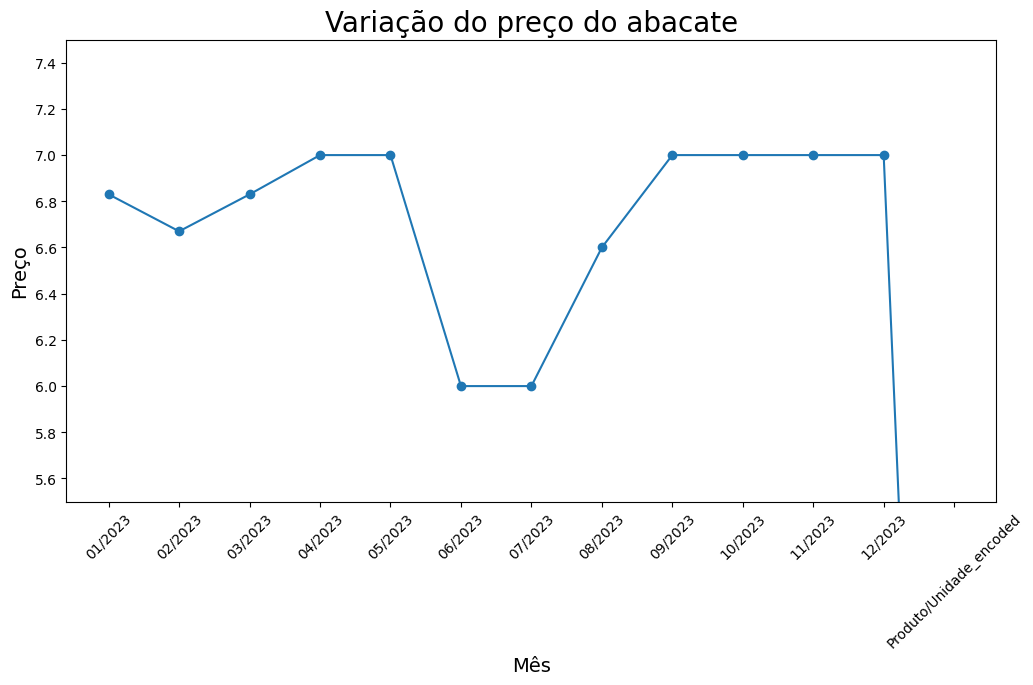

In [ ]:
# Criação de um DataFrame com os meses como índices
abacate = dados[dados['Produto/Unidade'] == 'ABACATE (kg)']

# Verificação para que somente os meses sejam incluídos
print("Meses:", meses)

# Obter somente os meses para o eixo x
meses = dados.columns[1:]

# Criação do gráfico
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(meses, abacate.iloc[0, 1:].values.flatten(), marker='o', linestyle='-')

# Configuração de título e rótulos
ax.set_title('Variação do preço do abacate', fontsize=20)
ax.set_xlabel('Mês', fontsize=14)
ax.set_ylabel('Preço', fontsize=14)
plt.xticks(rotation=45)

# Definição dos limites e intervalos do eixo y
ax.set_ylim(5.5, 7.5)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

# Exibição do gráfico
plt.show()

## **Regressão linear**

In [ ]:
# Variável dependente y
y = dados['Produto/Unidade_encoded']
y

0         0
2         1
3         2
4         3
26        5
       ... 
2001    342
2002    343
2003    344
2005    345
2006    346
Name: Produto/Unidade_encoded, Length: 351, dtype: int64

In [ ]:
# Variável explicativa X
X = dados[['01/2023','02/2023','03/2023','04/2023','05/2023','06/2023','07/2023','08/2023','09/2023','10/2023','11/2023','12/2023']]
X

,01/2023,02/2023,03/2023,04/2023,05/2023,06/2023,07/2023,08/2023,09/2023,10/2023,11/2023,12/2023
0,6.83,6.67,6.83,7.00,7.00,6.00,6.00,6.60,7.00,7.00,7.00,7.00
2,2.59,2.65,2.79,6.00,8.00,4.50,4.50,4.95,5.00,7.50,7.00,7.50
3,21.80,20.14,23.45,26.65,34.82,36.87,25.47,27.36,28.48,31.92,25.05,25.75
4,3.81,3.75,3.75,3.90,4.00,4.25,4.02,3.94,4.27,4.25,4.51,4.23
26,2.83,2.33,2.50,2.00,3.00,3.00,3.00,3.30,3.50,3.50,3.50,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...
2001,3.00,3.00,3.00,3.00,2.66,2.66,2.66,2.66,2.66,2.66,2.66,2.66
2002,3.10,3.36,3.11,2.60,2.70,2.76,2.66,3.35,3.64,3.70,3.73,3.99
2003,5.63,6.00,6.89,6.50,5.15,4.61,5.25,5.50,5.86,6.38,6.84,6.62
2005,4.32,4.39,4.99,6.20,6.33,6.42,7.21,7.22,7.19,7.29,5.77,5.35


In [ ]:
# Aplicanção do label encoding em 'Produto/Unidade'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Valores originais de y:", y.head())
print("Valores codificados de y:", y_encoded[:5])

Valores originais de y: 0     0
2     1
3     2
4     3
26    5
Name: Produto/Unidade_encoded, dtype: int64
Valores codificados de y: [0 1 2 3 5]


In [ ]:
# Criação do dataset de treino e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
X_train

,01/2023,02/2023,03/2023,04/2023,05/2023,06/2023,07/2023,08/2023,09/2023,10/2023,11/2023,12/2023
662,3.75,3.54,3.50,3.75,4.16,4.20,4.16,4.56,5.00,5.00,5.00,5.00
830,124.88,122.25,137.53,136.35,137.70,144.34,147.67,143.15,138.27,125.88,118.31,121.45
1224,8.00,8.33,8.43,8.00,7.50,9.50,9.00,9.90,10.00,10.00,10.00,10.00
1040,463.33,471.67,456.74,462.00,434.78,395.45,390.00,378.26,359.52,312.50,354.55,403.33
1291,660.83,644.67,676.11,663.43,662.27,649.14,618.81,618.40,574.93,598.50,588.92,581.59
...,...,...,...,...,...,...,...,...,...,...,...,...
1676,148.20,141.40,151.36,157.84,156.99,161.49,160.60,160.60,167.65,168.00,144.70,134.90
493,16.31,17.29,16.61,16.48,16.33,17.39,21.35,15.13,12.66,14.27,13.51,13.67
1427,112.90,119.11,120.00,120.00,120.00,120.41,125.87,125.87,125.87,125.87,141.69,138.60
1864,1.79,1.82,1.83,1.90,1.86,1.85,1.87,1.87,1.92,1.99,1.81,1.87


In [ ]:
# Instância da classe LinearRegression()
modelo = LinearRegression()

In [ ]:
# Remoção de linhas com valores ausentes
X_train_clean = X_train.dropna()
y_train_clean = y_train[X_train_clean.index]

# Verificação de NaNs nos dados limpos
print(X_train_clean.isnull().sum().sum())

0


In [ ]:
# Utilização do método fit() do objeto "modelo" para estimar o modelo linear utilizando os dados de treino
modelo.fit(X_train_clean, y_train_clean)

LinearRegression()

In [ ]:
# Remoção de linhas com valores ausentes
X_test_clean = X_test.dropna()
y_test_clean = y_test[X_test_clean.index]

# Verificação de NaNs nos dados limpos
print(X_test_clean.isnull().sum().sum())

0


In [ ]:
# Previsões para os dados de teste com predict() do objeto modelo
y_previsto = modelo.predict(X_test_clean)
y_previsto

array([173.49600349, 170.10519875, 165.44678583, 171.77229426,
       153.77432484, 175.92039902, 172.69004815, 176.34666721,
       184.61859711, 169.78901715, 176.73074696, 172.3422797 ,
       138.71665222, 171.51659617, 149.05370191, 153.07169439,
       161.72254253, 143.11097748, 155.7905095 , 168.39971128,
       213.4471538 , 220.12778735, 155.58627253, 166.81903197,
       169.74655924, 178.9023763 , 170.90400277, 171.4954181 ,
       170.32466406, 171.5273946 , 171.45934844, 173.10249265,
       171.50020421, 155.70523942, 171.5125153 , 172.71596854,
       172.51119623, 171.16472472, 168.94799492, 167.53762066,
       170.10773103, 171.94781701, 172.93026977, 167.79047361,
       174.06778395, 171.9412693 , 173.60910001, 171.4883937 ,
       170.98322377, 149.0339429 , 121.23640809, 170.80799073,
       171.78518753, 171.45781117, 174.84095242, 175.44526157,
       164.10526239, 171.46156501, 161.278419  , 170.05069815,
       171.34815182, 169.72617015, 171.65147962, 170.60

In [ ]:
y_test_clean

718     118
1241    216
855     165
2006    346
429      82
       ... 
1462    249
137      20
737     123
2001    342
827     155
Name: Produto/Unidade_encoded, Length: 104, dtype: int64

In [ ]:
y_previsto

array([173.49600349, 170.10519875, 165.44678583, 171.77229426,
       153.77432484, 175.92039902, 172.69004815, 176.34666721,
       184.61859711, 169.78901715, 176.73074696, 172.3422797 ,
       138.71665222, 171.51659617, 149.05370191, 153.07169439,
       161.72254253, 143.11097748, 155.7905095 , 168.39971128,
       213.4471538 , 220.12778735, 155.58627253, 166.81903197,
       169.74655924, 178.9023763 , 170.90400277, 171.4954181 ,
       170.32466406, 171.5273946 , 171.45934844, 173.10249265,
       171.50020421, 155.70523942, 171.5125153 , 172.71596854,
       172.51119623, 171.16472472, 168.94799492, 167.53762066,
       170.10773103, 171.94781701, 172.93026977, 167.79047361,
       174.06778395, 171.9412693 , 173.60910001, 171.4883937 ,
       170.98322377, 149.0339429 , 121.23640809, 170.80799073,
       171.78518753, 171.45781117, 174.84095242, 175.44526157,
       164.10526239, 171.46156501, 161.278419  , 170.05069815,
       171.34815182, 169.72617015, 171.65147962, 170.60

In [ ]:
# Coeficiente de determinação - R²
print(f'R² = {modelo.score(X_train_clean, y_train_clean).round(2)}')

R² = 0.06


In [ ]:
# Obtenção do coeficiente de determinação R² para as previsões do modelo
print(f'R² = {metrics.r2_score(y_test_clean, y_previsto).round(2)}')

R² = -0.08


## **Previsões pontuais**

In [ ]:
# Valores do produto 662
valores_prod_662 = [3.75, 3.54, 3.50, 3.75, 4.16, 4.20, 4.16, 4.56, 5.00, 5.00, 5.00, 5.00]

In [ ]:
# Transformação dos valores em um array 2D
entrada_prod_662 = np.array(valores_prod_662).reshape(1, -1)

In [ ]:
# Previsão pontual para o produto 662
previsao_prod_662 = modelo.predict(entrada_prod_662)

print(f'Previsão pontual para o produto/unidade 662: {previsao_prod_662}')

Previsão pontual para o produto/unidade 662: [170.02828164]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## **Protótipo Funcional**

In [ ]:
import pandas as pd

# Carregar o arquivo Excel
df = pd.read_excel('datasetIA.xlsx', sheet_name='Planilha1')

# Corrigir o nome da coluna com espaço extra
df.columns = df.columns.str.strip()

# Definir as porcentagens de acordo com cada critério
porcentagem_localizacao = {
    'RS': 0.02, 'SC': 0.02, 'PR': 0.01, 'SP': 0.02, 'RJ': 0.02, 'ES': 0,
    'MG': 0, 'MT': -0.01, 'MS': -0.01, 'GO': -0.01, 'AM': -0.02, 'AC': -0.02,
    'RO': -0.02, 'RR': -0.02, 'AP': -0.02, 'PA': 0, 'TO': -0.01, 'MA': 0,
    'PI': -0.01, 'BA': 0.02, 'CE': 0.01, 'RN': -0.01, 'SE': -0.02, 'AL': 0,
    'PE': 0.01, 'PB': -0.02
}

porcentagem_horario = {
    '00h-00h59': -0.01, '01h-01h59': -0.02, '02h-02h59': -0.02, '03h-03h59': -0.02,
    '04h-04h59': -0.02, '05h-05h59': -0.01, '06h-06h59': -0.01, '07h-07h59': 0,
    '08h-08h59': 0, '09h-09h59': 0.01, '10h-10h59': 0.01, '11h-11h59': 0.02,
    '12h-12h59': 0.02, '13h-13h59': 0.01, '14h-14h59': 0.01, '15h-15h59': 0,
    '16h-16h59': 0, '17h-17h59': 0, '18h-18h59': 0.01, '19h-19h59': 0.01,
    '20h-20h59': 0.02, '21h-21h59': 0.01, '22h-22h59': 0, '23h-23h59': 0
}

porcentagem_clima = {
    '1º a 5º': 0.01, '6º a 10º': 0.02, '11º a 15º': -0.02, '16º a 19º': -0.01,
    '20º a 23º': 0, '24º a 26º': 0, '27º a 29º': 0.01, '30º a 34º': 0.01,
    '35º a 39º': 0.02, '+40º': 0.02
}

porcentagem_procura = {
    '1x': 0, '2 a 3x': 0.003, '4 a 7x': 0.008, '8 a 13x': 0, '14 a 17x': -0.002,
    '17 a 20x': 0.001, '+21x': 0
}

porcentagem_demanda = {
    'Alta': 0.02, 'Média': 0, 'Baixa': -0.01
}

# Função para aplicar as porcentagens no preço
def calcular_variacao(row):
    try:
        # Definir um preço inicial fictício, por exemplo, 100
        preco_base = 100

        # Calcular as variações baseadas em Localização, Horário, Clima, Procura, e Demanda
        variacao_localizacao = porcentagem_localizacao.get(row['Localização'], 0)

        # Ajustar o horário para o formato 'HH:MM'
        horario = str(row['Horário'])  # Garantir que é uma string
        hora = int(horario[:2])

        # Determinar a faixa horária
        if 0 <= hora < 1:
            faixa_horaria = '00h-00h59'
        elif 1 <= hora < 2:
            faixa_horaria = '01h-01h59'
        elif 2 <= hora < 3:
            faixa_horaria = '02h-02h59'
        elif 3 <= hora < 4:
            faixa_horaria = '03h-03h59'
        elif 4 <= hora < 5:
            faixa_horaria = '04h-04h59'
        elif 5 <= hora < 6:
            faixa_horaria = '05h-05h59'
        elif 6 <= hora < 7:
            faixa_horaria = '06h-06h59'
        elif 7 <= hora < 8:
            faixa_horaria = '07h-07h59'
        elif 8 <= hora < 9:
            faixa_horaria = '08h-08h59'
        elif 9 <= hora < 10:
            faixa_horaria = '09h-09h59'
        elif 10 <= hora < 11:
            faixa_horaria = '10h-10h59'
        elif 11 <= hora < 12:
            faixa_horaria = '11h-11h59'
        elif 12 <= hora < 13:
            faixa_horaria = '12h-12h59'
        elif 13 <= hora < 14:
            faixa_horaria = '13h-13h59'
        elif 14 <= hora < 15:
            faixa_horaria = '14h-14h59'
        elif 15 <= hora < 16:
            faixa_horaria = '15h-15h59'
        elif 16 <= hora < 17:
            faixa_horaria = '16h-16h59'
        elif 17 <= hora < 18:
            faixa_horaria = '17h-17h59'
        elif 18 <= hora < 19:
            faixa_horaria = '18h-18h59'
        elif 19 <= hora < 20:
            faixa_horaria = '19h-19h59'
        elif 20 <= hora < 21:
            faixa_horaria = '20h-20h59'
        elif 21 <= hora < 22:
            faixa_horaria = '21h-21h59'
        elif 22 <= hora < 23:
            faixa_horaria = '22h-22h59'
        else:
            faixa_horaria = '23h-23h59'

        variacao_horario = porcentagem_horario.get(faixa_horaria, 0)

        # Calcular a variação de clima
        clima = row['Clima']
        variacao_clima = 0
        for faixa, variacao in porcentagem_clima.items():
            if faixa.startswith('+') or faixa.startswith('-'):
                limites = faixa.split('º a ')
                if len(limites) == 2:
                    limite_inferior = int(limites[0].replace('º', ''))
                    limite_superior = int(limites[1].replace('º', ''))
                    if limite_inferior <= clima <= limite_superior:
                        variacao_clima = variacao
                        break
                else:
                    limite_inferior = int(limites[0].replace('+', '').replace('º', ''))
                    if clima >= limite_inferior:
                        variacao_clima = variacao
                        break
            else:
                if faixa == f'{clima}':
                    variacao_clima = variacao
                    break

        variacao_procura = porcentagem_procura.get(row['Procura'], 0)
        variacao_demanda = porcentagem_demanda.get(row['Demanda'], 0)

        # Calcular o novo preço com base nas variações
        preco_final = preco_base * (1 + variacao_localizacao + variacao_horario +
                                    variacao_clima + variacao_procura + variacao_demanda)

        return preco_final
    except Exception as e:
        print(f"Erro ao processar a linha: {row}. Erro: {e}")
        return None

# Aplicar a função ao dataset
df['Preço Final'] = df.apply(calcular_variacao, axis=1)

# Verificar se há problemas na atribuição dos dados
print(df[['Nome', 'Produto', 'Localização', 'Horário', 'Clima', 'Procura', 'Demanda', 'Preço Final']].head())
